## Estimate Posterior using MCMC
study group tutorial 16jan19 / jplewis

source is in D/Julia/Learning, not Notes/Notebooks

In [13]:
using PyPlot
p_ = PyPlot

PyPlot

### test out Distributions package

In [14]:
using Distributions
noisesigma = 0.1
noise = Distributions.Normal(0., noisesigma)
gaussian(val,μ,σ) = (1. /sqrt(2. * π * σ^2 )) * exp( - (val-μ)^2 / (2. * σ^2))
(gaussian(2.3,0,noisesigma), Distributions.pdf(noise,2.3))
(gaussian(-0.3,0,noisesigma), Distributions.pdf(noise,-0.3))   # same

(0.044318484119380115, 0.044318484119380115)

### model

A,B ~ N(0,1)

$y = A x + B + \epsilon$

### true parameter values

In [15]:
N = 5  # data points
A = randn()
B = randn()
(A,B)

(-1.183395887938753, -0.6008689825449511)

### Generate sample data

In [16]:
ϵ = noisesigma * randn(N,)   # todo use Distributions package sample
x = 2. * randn(N,)
y = A * x .+ B .+ ϵ

5-element Array{Float64,1}:
 -0.4040311439897141
  2.6768620555235674
 -1.4600349109895314
  0.660426325086898 
  1.645982470697569 

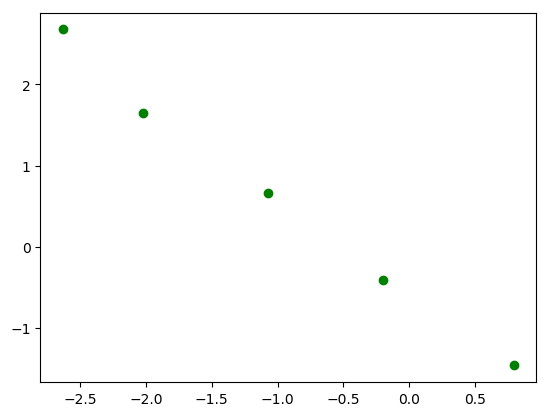

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x13c79e4e0>

In [17]:
p_.plot(x,y,"go")

### Note likelihood (and improper prior) cancel
General Bayes thm:
$$
    p(M|D) = \frac{ p(D|M) p(M)   }{ p(D)  } = \frac{ p(D|M) p(M)   }{ \int p(D|M) p(M) \, dM   }
$$

For the case of regression:
\begin{align*}
P(\theta|y,x) &= \frac{P(\theta,y,x)}{ P(y,x) }
\\
    &= \frac{ P(y|x,\theta) P(x|\theta) P(\theta) }{ P(y|x) P(x)  }
\\
    P(x|\theta) = P(x) \quad\text{and cancel}  &
\\
    &=  \frac{ P(y|x,\theta) P(\theta) }{ P(y|x) }
\\
\end{align*}

Posterior odds

\begin{align*}
   \frac{ P(\theta_1|y,x) }{ P(\theta|y,x) } &=   \frac{ \frac{ P(y|x,\theta_1) P(\theta_1) }{ P(y|x) } }{ \frac{ P(y|x,\theta) P(\theta) }{ P(y|x) } }     \quad=\quad  \frac{ P(y|x,\theta_1) P(\theta_1) }{  P(y|x,\theta) P(\theta)  }
\end{align*}

For the case of Gaussian noise $\epsilon$
$$
P(y|x,\theta) = \prod \frac{1}{\sqrt{ 2 \pi \sigma^2}} \exp(- \frac{1}{2}|y_i - (a x_i + b)|^2 / \sigma^2) 
$$

log likelihood = 

$$ 
-\frac{N}{2}\log(2 \pi \sigma^2) \quad-\quad  \left( \sum |y_i - (a x_i + b)|^2 / (2\sigma^2) \right) 
$$

(details)

\begin{align*}
&   \log \frac{1}{\sqrt{2 \pi \sigma^2}}
\\
&= \log 1  - \log ( 2 \pi \sigma^2 )^{1/2}
 \\
&=   0  - \frac{1}{2} \log{ 2 \pi \sigma^2}
\end{align*}

In [18]:
function loglikelihood(a,b)
    noisesigma2 = noisesigma*noisesigma
    ll = 0.
    for ipt = 1:N
        #print("  datapoint $ipt ")
        err = y[ipt] - (a*x[ipt]+b)
        peval = err*err / (2*noisesigma2)
        #print(" p0eval=",peval)
        ll -= peval
    end 
    ll -= (N/2.)*log(2*π*noisesigma2)
    ll
end

loglikelihood (generic function with 1 method)

In [19]:
normal = Distributions.Normal(0., 1.0 )
function logposterior(a,b)
    useprior = false   # else improper/flat prior
    prior = 0.
    if useprior
        prior += log(Distributions.pdf(normal,a))
        prior += log(Distributions.pdf(normal,b))
    end
    prior + loglikelihood(a,b)
end

logposterior (generic function with 1 method)

Stopping test, log version

$$
\frac{ \exp(n)}{\exp(d)} > 1  \quad\rightarrow\quad   n - d > 0 
$$

In [20]:
function mcmc1logposterior(a,b)
    println("mcmc1logposterior initial $a $b")
    
    logposterior0 = logposterior(a,b)
    
    for mciter = 1:100
        if ((mciter%10)==0) println("  mciter $mciter")  end
        a_ = a + 0.5 * randn()
        b_ = b + 0.5 * randn()       # new proposal
        
        logposterior1 = logposterior(a_,b_)
        
        #println("logp1 $logposterior1,   logp0 $logposterior0")

        p = exp(logposterior1) / exp(logposterior0)
        if (rand() < p)
            println("\nsuccess $a_, $b_")
            return (a_,b_)
        else
            print(".")
        end   
    end
    println("")
    return (a,b)
end

mcmc1logposterior (generic function with 1 method)

In [21]:
function warmup(a,b) 
    for iter = 1:1000 
        if ((iter%10)==0) println("iter $iter")  end
        a,b = mcmc1logposterior(a,b)   
    end
    return (a,b)
end                # warmup


warmup (generic function with 1 method)

In [22]:
function mcmcline(a,b)
    aavg, bavg = (0.,0.)
    Niter = 100000
    for iter = 1:Niter 
        if ((iter%10)==0) println("iter $iter")  end
        a,b = mcmc1logposterior(a,b)   
        aavg += a
        bavg += b
    end
    aavg /= float(Niter)
    bavg /= float(Niter)
    return (aavg,bavg)
end

mcmcline (generic function with 1 method)

In [23]:
# initial posterior estimate
a_, b_ = 0.,0.

a_, b_ = warmup(a_,b_)
aest, best = mcmcline(a_,b_)

print("estimate $aest, $best,   true $A, $B")

mcmc1logposterior initial 0.0 0.0

success -0.18364691731280072, 0.27610344180091445
mcmc1logposterior initial -0.18364691731280072 0.27610344180091445
.
success -0.20774358844916568, 0.21608156230258802
mcmc1logposterior initial -0.20774358844916568 0.21608156230258802
.
success -0.46291661354458774, 0.30532851018577906
mcmc1logposterior initial -0.46291661354458774 0.30532851018577906

success -0.8970685275915198, 0.23188298094542475
mcmc1logposterior initial -0.8970685275915198 0.23188298094542475
.
success -0.7375519862392044, 0.08360553820986996
mcmc1logposterior initial -0.7375519862392044 0.08360553820986996
.
success -1.4540720861061343, -0.9938357525509156
mcmc1logposterior initial -1.4540720861061343 -0.9938357525509156
.........  mciter 10
.......
success -1.3721335349939838, -0.7428595217598929
mcmc1logposterior initial -1.3721335349939838 -0.7428595217598929
.........  mciter 10
....
success -1.3121817802965177, -0.8359676519780151
mcmc1logposterior initial -1.312181780296

..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.173622341010359 -0.5476970787098839
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.173622341010359 -0.5476970787098839
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..
success -1.2375175555736573, -0.6613686906954351
mcmc1logposterior initial -1.2375175555736573 -0.6613686906954351
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100


.........  mciter 10
.......
success -1.170155482006581, -0.4755020989887303
iter 110
mcmc1logposterior initial -1.170155482006581 -0.4755020989887303
.........  mciter 10
.
success -1.220293457564346, -0.7253209691767738
mcmc1logposterior initial -1.220293457564346 -0.7253209691767738
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
...
success -1.2269538863206195, -0.5213060309347746
mcmc1logposterior initial -1.2269538863206195 -0.5213060309347746
.....
success -1.2106528266072831, -0.7386478545324383
mcmc1logposterior initial -1.2106528266072831 -0.7386478545324383
.........  mciter 10
.....
success -1.1381089527309243, -0.6370105151868806
mcmc1logposterior initial -1.1381089527309243 -0.6370105151868806
.
success -1.2155452391348873, -0.5724424966988518
mcmc1logposterior initial -1.2155452391348873 -0.5724424966988518
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter

.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.1424101969004288 -0.5495825037891808
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
.....
success -1.2356614028984063, -0.6321391982486475
mcmc1logposterior initial -1.2356614028984063 -0.6321391982486475
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
...
success -1.202679164275755, -0.589229677354552
mcmc1logposterior initial -1.202679164275755 -0.589229677354552
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.202679164275755 -0.589229677354552
.........  mcite

..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
.....
success -1.1349369753497918, -0.5462919299186035
mcmc1logposterior initial -1.1349369753497918 -0.5462919299186035
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
...
success -1.2199193986832897, -0.6044241918629809
mcmc1logposterior initial -1.2199193986832897 -0.6044241918629809
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.2199193986832897 -0.6044241918629809
...
success -1.131671743620473, -0.5239197261812975
mcmc1logposterior initial -1.131671743620473 -0.5239197261812975
.........  mciter 10
..........  mciter 20
..........  mciter 30
.....
success -1.2314669186807912, -0.6849142754877114
mcmc1logposterior initial -1.231466918

..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.1957395028999136 -0.6566679983652819
.........  mciter 10
..........  mciter 20
.....
success -1.220054454343251, -0.5680823731212846
mcmc1logposterior initial -1.220054454343251 -0.5680823731212846
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
....
success -1.0879110637528995, -0.4482923183850064
mcmc1logposterior initial -1.0879110637528995 -0.4482923183850064
.........  mciter 10
..........  mciter 20
..
success -1.2242271185710385, -0.636105478217295
mcmc1logposterior initial -1.2242271185710385 -0.636105478217295
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1

..........  mciter 100
.
mcmc1logposterior initial -1.1480206163252946 -0.5385007642886535
.........  mciter 10
..........  mciter 20
.....
success -1.199444088565963, -0.5517542711611322
iter 340
mcmc1logposterior initial -1.199444088565963 -0.5517542711611322
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
....
success -1.1847378732297973, -0.6702326519292361
mcmc1logposterior initial -1.1847378732297973 -0.6702326519292361
.........  mciter 10
.
success -1.2280285128501078, -0.724896194194987
mcmc1logposterior initial -1.2280285128501078 -0.724896194194987
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
......
success -1.2141866992415722, -0.5072974612219814
mcmc1logposterior initial -1.2141866992415722 -0.5072974612219814
.........  mciter 10
..........  mciter 20
..........  mciter 30
.......
suc

..........  mciter 20
..........  mciter 30
..
success -1.2203065332229335, -0.6224706404011692
iter 420
mcmc1logposterior initial -1.2203065332229335 -0.6224706404011692
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
....
success -1.1948847557209397, -0.5736741421389892
mcmc1logposterior initial -1.1948847557209397 -0.5736741421389892
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
.
success -1.1314441919463059, -0.522563740932952
mcmc1logposterior initial -1.1314441919463059 -0.522563740932952
..
success -1.1572215227181053, -0.5694187559739395
mcmc1logposterior initial -1.1572215227181053 -0.5694187559739395
.........  mciter 10
..........  mciter 20
.....
success -1.2103499360722243, -0.5499374652564019
mcmc1logposterior initial -1.2103499360722243 -0.5

mcmc1logposterior initial -1.1671445684343076 -0.5422112944589486
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.1671445684343076 -0.5422112944589486
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.1671445684343076 -0.5422112944589486
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.1671445684343076 -0.5422112944589486
.........  mciter 10
..........  mciter 20
..........  mciter 30
.....

mcmc1logposterior initial -1.22642165284096 -0.6101386922102906
.........  mciter 10
...
success -1.2214170715500228, -0.6326869787058259
iter 520
mcmc1logposterior initial -1.2214170715500228 -0.6326869787058259
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.2214170715500228 -0.6326869787058259
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
.......
success -1.1588324408990243, -0.5420743675288516
mcmc1logposterior initial -1.1588324408990243 -0.5420743675288516
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.1588324408990243

mcmc1logposterior initial -1.2055622614122414 -0.5914543945762942
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.2055622614122414 -0.5914543945762942
.........  mciter 10
..........  mciter 20

success -1.1951804018555523, -0.6471782661269316
mcmc1logposterior initial -1.1951804018555523 -0.6471782661269316
.........  mciter 10
.........
success -1.1869661314222704, -0.6337126734379328
mcmc1logposterior initial -1.1869661314222704 -0.6337126734379328
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
.......
success -1.2026716248875988, -0.5564799493168883
mcmc1logposterior initial -1.2026716248875988 -0.5564799493168883
.........  mciter 10
..........  mciter 20


..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
iter 600
mcmc1logposterior initial -1.1478069780921394 -0.5640652745507577
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.1478069780921394 -0.5640652745507577
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.1478069780921394 -0.5640652745507577
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mcite

..........  mciter 80
..........  mciter 90
..
success -1.225206337036267, -0.5885342420924663
mcmc1logposterior initial -1.225206337036267 -0.5885342420924663
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..
success -1.192609073064925, -0.6104251750474349
mcmc1logposterior initial -1.192609073064925 -0.6104251750474349
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.192609073064925 -0.6104251750474349
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
iter 650
mcmc1logposterior initial -1.192609073064925 -0.61042

mcmc1logposterior initial -1.1505591720648147 -0.486157797598051
.........  mciter 10
..........  mciter 20
..........  mciter 30
.........
success -1.2282645284142286, -0.5646675283618973
mcmc1logposterior initial -1.2282645284142286 -0.5646675283618973
.........  mciter 10
........
success -1.1708119640230752, -0.4633229657972779
mcmc1logposterior initial -1.1708119640230752 -0.4633229657972779
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
.....
success -1.2725682748067815, -0.663416263323343
mcmc1logposterior initial -1.2725682748067815 -0.663416263323343
.........  mciter 10
..........  mciter 20

success -1.2531136416545594, -0.7518601881819634
mcmc1logposterior initial -1.2531136416545594 -0.7518601881819634
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..
success -1.2987563626451328, -0.6978800256915021
mcmc1logposterior initial -1.2987563626451328 -0.697

..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
.
success -1.2211801683372856, -0.6900393000181706
mcmc1logposterior initial -1.2211801683372856 -0.6900393000181706
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.2211801683372856 -0.6900393000181706
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
...
success -1.1336896842887765, -0.5140788765963274
mcmc1logposterior initial -1.1336896842887765 -0.5140788765963274
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
........
success -1.1888568138213294, -0.6940941437260573
mcmc1logposterior initia

..........  mciter 60
..........  mciter 70
..........  mciter 80

success -1.2346455402175636, -0.6149915813062444
mcmc1logposterior initial -1.2346455402175636 -0.6149915813062444
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.2346455402175636 -0.6149915813062444
.........  mciter 10
..........  mciter 20
..........  mciter 30
......
success -1.180101993574749, -0.6978123120502697
mcmc1logposterior initial -1.180101993574749 -0.6978123120502697
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
........
success -1.2192277432483338, -0.5840096321932556
mcmc1logposterior initial -1.2192277432483338 -0.5840096321932556
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
...

success -1.2764809243025916, -0.7068326831036152
mcmc1logposterior initial -1.2764809243025916 -0.7068326831036152
.........  mciter 10
......
success -1.2184228247475872, -0.5860818854214169
mcmc1logposterior initial -1.2184228247475872 -0.5860818854214169
.........  mciter 10

success -1.163857771220495, -0.590865723955844
mcmc1logposterior initial -1.163857771220495 -0.590865723955844
.........  mciter 10
....
success -1.179919384815397, -0.5749736120718965
mcmc1logposterior initial -1.179919384815397 -0.5749736120718965
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
........
success -1.196530701548747, -0.5875967463391687
iter 860
mcmc1logposterior initial -1.196530701548747 -0.5875967463391687
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70

success -1.245146587370124, -0.7365038491866183
mcmc1logposterior initial -1.245146587370124 -0.73

..........  mciter 50
..........  mciter 60
..........  mciter 70
...
success -1.1238509854912042, -0.5459613638996839
mcmc1logposterior initial -1.1238509854912042 -0.5459613638996839
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
...
success -1.1366402529774076, -0.6037978048193726
mcmc1logposterior initial -1.1366402529774076 -0.6037978048193726
.....
success -1.1491934815013285, -0.6299613028076572
mcmc1logposterior initial -1.1491934815013285 -0.6299613028076572
.........  mciter 10
..........  mciter 20
.....
success -1.149017931050067, -0.47117467676068236
mcmc1logposterior initial -1.149017931050067 -0.47117467676068236
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.149017931050067 -0.47117467676068236
.....
success -1.2113258117619996, -

..........  mciter 40
..........  mciter 50
..........  mciter 60
...
success -1.1836793617586132, -0.5385953190513032
mcmc1logposterior initial -1.1836793617586132 -0.5385953190513032
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.1836793617586132 -0.5385953190513032
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
......
success -1.233532702983321, -0.6634589253203391
iter 980
mcmc1logposterior initial -1.233532702983321 -0.6634589253203391
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40

success -1.1940264384633574, -0.6153368874491089
mcmc1logposterior initial -1.1940264384633574 -0.6153368874491089
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40

mcmc1logposterior initial -1.1514938537676664 -0.46769930376618235
...
success -1.1120952704217426, -0.5691321294415547
mcmc1logposterior initial -1.1120952704217426 -0.5691321294415547
.........  mciter 10
..........  mciter 20
......
success -1.1388092797695364, -0.5987664037728052
iter 30
mcmc1logposterior initial -1.1388092797695364 -0.5987664037728052
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.1388092797695364 -0.5987664037728052
.........  mciter 10
.....
success -1.079300750896037, -0.5378878197325155
mcmc1logposterior initial -1.079300750896037 -0.5378878197325155
.........  mciter 10
....
success -1.0783799351505743, -0.4561243210981232
mcmc1logposterior initial -1.0783799351505743 -0.4561243210981232
.........  mciter 10
..........  mciter 20
..........  mciter 30
.......

..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.1544720377729112 -0.5951091757226527
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.1544720377729112 -0.5951091757226527
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.1544720377729112 -0.5951091757226527
.........  mciter 10
.....
success -1.1262716763699068, -0.46979489293402954
iter 80
mcmc1logposterior initial -1.1262716763699068 -0.46979489293402954
...
success -1.1987862601830328, -0.5995894169720541
mcmc1logposterior initial -1.1987862601830328 -0.5995894169720541
.........  mciter 

..........  mciter 20
....
success -1.2807645109666868, -0.7023918268781987
mcmc1logposterior initial -1.2807645109666868 -0.7023918268781987
.........  mciter 10
.......
success -1.1568744266262658, -0.5666004028097034
mcmc1logposterior initial -1.1568744266262658 -0.5666004028097034
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.1568744266262658 -0.5666004028097034
.........  mciter 10
..........  mciter 20
..........  mciter 30
......
success -1.1578958787109837, -0.5372853856527993
mcmc1logposterior initial -1.1578958787109837 -0.5372853856527993
.........  mciter 10
.......
success -1.2360680727733504, -0.6419288557617304
mcmc1logposterior initial -1.2360680727733504 -0.6419288557617304
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
........

mcmc1logposterior initial -1.159133040865856 -0.6292994086530119
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
.
success -1.2207864263788137, -0.6350080175867104
mcmc1logposterior initial -1.2207864263788137 -0.6350080175867104
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
iter 190
mcmc1logposterior initial -1.2207864263788137 -0.6350080175867104
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
........
success -1.1578542672761902, -0.5901472520540243
mcmc1logposterior initial -1.1578542672761902 -0.5901472520540243
.........  mciter 10
..........  mciter 20
..........  mciter 30
.
success -1.1716624903582715, -0.508308393527096
mcmc1logposterior in

..........  mciter 60
........
success -1.1832066052373902, -0.5568196582495516
mcmc1logposterior initial -1.1832066052373902 -0.5568196582495516
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..
success -1.1536972923406643, -0.5304427755218267
mcmc1logposterior initial -1.1536972923406643 -0.5304427755218267
.........  mciter 10
..........  mciter 20
....
success -1.124005954064466, -0.55833299412636
mcmc1logposterior initial -1.124005954064466 -0.55833299412636
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
........
success -1.146769136445463, -0.5755477040608836
mcmc1logposterior initial -1.146769136445463 -0.5755477040608836
.........  mciter 10
..........  mciter 20
..........  mciter 30
......
success -1.1667650198251955, -0.5672813826492338
mcmc1logposterior initial -1.1667650198251955 -0.567

..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.1736558951731488 -0.6040313778298981
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
.....
success -1.2023614785470746, -0.6555482584770698
mcmc1logposterior initial -1.2023614785470746 -0.6555482584770698
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40

success -1.2257754013702404, -0.5515515120029009
iter 280
mcmc1logposterior initial -1.2257754013702404 -0.5515515120029009
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.2257754013702404 -0.5515515120029009
.........  mciter 10
..........  mciter 20
....

..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.1726212343283784 -0.5888424178905962
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
...
success -1.1723127074354782, -0.5949382212917338
mcmc1logposterior initial -1.1723127074354782 -0.5949382212917338
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.1723127074354782 -0.5949382212917338
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 1

mcmc1logposterior initial -1.2065927474492082 -0.6621789798842227
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
......
success -1.2186178731104846, -0.585975116743518
mcmc1logposterior initial -1.2186178731104846 -0.585975116743518
.
success -1.140210818803768, -0.5949009052076439
iter 370
mcmc1logposterior initial -1.140210818803768 -0.5949009052076439
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
........
success -1.2093604280955725, -0.6289256286605506
mcmc1logposterior initial -1.2093604280955725 -0.6289256286605506
.........  mciter 10
..
success -1.1679237839847667, -0.6545431991918612
mcmc1logposterior initial -1.1679237839847667 -0.6545431991918612
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
........
success -1.1233830233927788, -0.501718742041529
mcmc1logposterior ini

..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.1580189292897263 -0.5140113423963277
.........  mciter 10
..........  mciter 20
.......
success -1.248860469860017, -0.6204951197201827
iter 420
mcmc1logposterior initial -1.248860469860017 -0.6204951197201827
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80

success -1.220358674088511, -0.5571436926866619
mcmc1logposterior initial -1.220358674088511 -0.5571436926866619
.........  mciter 10
....
success -1.2027023773730965, -0.6164495240071217
mcmc1logposterior initial -1.2027023773730965 -0.6164495240071217
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80

..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.1540240769010826 -0.6368840499367842
.........  mciter 10
..........  mciter 20

success -1.2606483798098067, -0.656135938432179
mcmc1logposterior initial -1.2606483798098067 -0.656135938432179
.......
success -1.2340983388337543, -0.6623146674724433
iter 490
mcmc1logposterior initial -1.2340983388337543 -0.6623146674724433
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.2340983388337543 -0.6623146674724433
...
success -1.1445869649894884, -0.4715249716620683
mcmc1logposterior initial -1.1445869649894884 -0.4715249716620683
.........  mciter 10
.......
success -1.1654263411133807, -0.6796695293228008
mcm

....
success -1.1602409983839161, -0.5728742577546238
mcmc1logposterior initial -1.1602409983839161 -0.5728742577546238
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
iter 530
mcmc1logposterior initial -1.1602409983839161 -0.5728742577546238
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
.....
success -1.1564484042092273, -0.5252166151400809
mcmc1logposterior initial -1.1564484042092273 -0.5252166151400809
.........  mciter 10
......
success -1.1469300616639313, -0.5472471684880659
mcmc1logposterior initial -1.1469300616639313 -0.5472471684880659
.........  mciter 10
..........  mciter 20
....
success -1.1756297645591307, -0.638169362688813
mcmc1logposterior initial -1.1756297645591307 -0

..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.1625078170385577 -0.5962240056697912
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
.........
success -1.1372177114514401, -0.540644531472178
mcmc1logposterior initial -1.1372177114514401 -0.540644531472178
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
.
success -1.1970608602432264, -0.5703773923835725
mcmc1logposterior initial -1.1970608602432264 -0.5703773923835725
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
.
success -1.1776431510292913, -0.5502213306408795
mcmc1logposterior initial -1.1776431510292913 -0.5502213306408795
.........  mciter 10
..........  mciter 20
..........  mciter 30
......

..........  mciter 60
.....
success -1.1711471114477956, -0.5823427902322815
mcmc1logposterior initial -1.1711471114477956 -0.5823427902322815
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.1711471114477956 -0.5823427902322815
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
.........
success -1.138646640555417, -0.5284224146475518
mcmc1logposterior initial -1.138646640555417 -0.5284224146475518
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..
success -1.2214779601018129, -0.6708325366491195
mcmc1logposterior initial -1.2214779601018129 -0.6708325366491195
.........  mciter 10
..........  mciter 20
...
success -1.1619979850154252, -0.497318614741568
mcmc1logposterior initial -1.16199798

mcmc1logposterior initial -1.119684726652813 -0.5464943269732562
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.119684726652813 -0.5464943269732562
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.119684726652813 -0.5464943269732562
.........  mciter 10
..........  mciter 20
..........  mciter 30
..
success -1.1799644864907333, -0.5087153629912605
mcmc1logposterior initial -1.1799644864907333 -0.5087153629912605
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
...

..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.208389562896366 -0.6084573637253258
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80

success -1.2241625867342452, -0.6471494774897834
mcmc1logposterior initial -1.2241625867342452 -0.6471494774897834
.........  mciter 10
..
success -1.154629064649097, -0.5833169439046582
mcmc1logposterior initial -1.154629064649097 -0.5833169439046582
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
.......
success -1.1624903849759953, -0.5710219755544856
mcmc1logposterior initial -1.1624903849759953 -0.5710219755544856
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
.
success

..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
....
success -1.2363528601792513, -0.6085929863296455
mcmc1logposterior initial -1.2363528601792513 -0.6085929863296455
....
success -1.2323301897135692, -0.7013105229433392
mcmc1logposterior initial -1.2323301897135692 -0.7013105229433392
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
.
success -1.1329432369761374, -0.5112822119090376
mcmc1logposterior initial -1.1329432369761374 -0.5112822119090376
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.1329432369761374 -0.5112822119090376
.........  mciter 10
..........  mciter 20
...
success -1.117217046457

.........
success -1.2216688457056017, -0.7275431907659009
mcmc1logposterior initial -1.2216688457056017 -0.7275431907659009
.........  mciter 10
..........  mciter 20
.....
success -1.1765935190674846, -0.48429020447779236
mcmc1logposterior initial -1.1765935190674846 -0.48429020447779236
.........  mciter 10
..........  mciter 20
....
success -1.1671185355676263, -0.6157654276598686
iter 850
mcmc1logposterior initial -1.1671185355676263 -0.6157654276598686
.....
success -1.116187345701729, -0.49533754637952127
mcmc1logposterior initial -1.116187345701729 -0.49533754637952127
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
.
success -1.1131875445511015, -0.5221633196230924
mcmc1logposterior initial -1.1131875445511015 -0.5221633196230924
.......
success -1.158947502986077, -0.5088031375391501
mcmc1logposterior initial -1.158947502986077 -0.5088031375391501
.........  mciter 10
..........  mciter 20
....

.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
....
success -1.224904293613684, -0.6607504547969162
mcmc1logposterior initial -1.224904293613684 -0.6607504547969162
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
...
success -1.1373741027162576, -0.598136689255768
mcmc1logposterior initial -1.1373741027162576 -0.598136689255768
.........  mciter 10
.
success -1.1614077030023533, -0.4929032311649545
mcmc1logposterior initial -1.1614077030023533 -0.4929032311649545
.........  mciter 10
......
success -1.207531533314264, -0.5897227592960737
mcmc1logposterior initial -1.207531533314264 -0.5897227592960737
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
it

..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.1806882123518232 -0.5854924480435223
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.1806882123518232 -0.5854924480435223
.........  mciter 10
..........  mciter 20
...
success -1.266592094354229, -0.6680997719465458
mcmc1logposterior initial -1.266592094354229 -0.6680997719465458
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..
success -1.1408764838934464, -0.6090869108656308
mcmc1logposterior initial -1.1408764838934464 -0.6090869108656308
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mci

..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.2183219201765156 -0.6518203253457254
..
success -1.1629313904095284, -0.5796933687861302
mcmc1logposterior initial -1.1629313904095284 -0.5796933687861302
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.1629313904095284 -0.5796933687861302
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.1629313904095284 -0.5796933687861302
.........  mciter 10
..........  mciter 20
..........  mciter

..........  mciter 100
.
mcmc1logposterior initial -1.165569882041893 -0.6348082601555869
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
.
success -1.1485875733602855, -0.5860930021876168
mcmc1logposterior initial -1.1485875733602855 -0.5860930021876168
.........  mciter 10
..........  mciter 20
..........  mciter 30
..
success -1.1202873074571704, -0.49382872589412985
mcmc1logposterior initial -1.1202873074571704 -0.49382872589412985
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
.
success -1.1989897121365611, -0.6515906887692824
mcmc1logposterior initial -1.1989897121365611 -0.6515906887692824
.........  mciter 10
..........  mciter 20

success -1.2011343006832789, -0.658127638525366
mcmc1logposterior initial -1.2011343006832789 -0.658127638525366
.........  mciter 10
..........  mciter 20
...
success -1.2366931336763003, -0.6155219968116257
mcmc1logposterior in

mcmc1logposterior initial -1.164412180417931 -0.6693140952080386
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
.....
success -1.101020587698371, -0.46539822611421755
iter 1120
mcmc1logposterior initial -1.101020587698371 -0.46539822611421755

success -1.196583415234433, -0.5211394497094654
mcmc1logposterior initial -1.196583415234433 -0.5211394497094654
.........  mciter 10
.......
success -1.1793561453932089, -0.5026008911357073
mcmc1logposterior initial -1.1793561453932089 -0.5026008911357073
.........  mciter 10
..
success -1.1130512046541392, -0.5021904956135482
mcmc1logposterior initial -1.1130512046541392 -0.5021904956135482
.........  mciter 10
.....
success -1.1741095162241104, -0.6780815145762873
mcmc1logposterior initial -1.1741095162241104 -0.6780815145762873
.........  mciter 10

success -1.2044494073846643, -0.5646502298272654
mcmc1logposterior initial -1.2044494073846643 -0.56465022982726


success -1.1981535529492822, -0.6376331093401643
mcmc1logposterior initial -1.1981535529492822 -0.6376331093401643
.........  mciter 10
..........  mciter 20
........
success -1.1992293133719971, -0.5648486918183634
mcmc1logposterior initial -1.1992293133719971 -0.5648486918183634
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
iter 1170
mcmc1logposterior initial -1.1992293133719971 -0.5648486918183634
.........  mciter 10
.
success -1.1175387501284022, -0.536706813708689
mcmc1logposterior initial -1.1175387501284022 -0.536706813708689
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.1175387501284022 -0.536706813708

mcmc1logposterior initial -1.1856606786915165 -0.617054516249265
.........  mciter 10
..........  mciter 20
..........  mciter 30
.
success -1.2450197965175342, -0.65340401058794
mcmc1logposterior initial -1.2450197965175342 -0.65340401058794
.........  mciter 10
..........  mciter 20
..........  mciter 30
...
success -1.167236831318284, -0.6284847703230734
mcmc1logposterior initial -1.167236831318284 -0.6284847703230734
.........  mciter 10
......
success -1.2421763378798816, -0.6500840617803365
mcmc1logposterior initial -1.2421763378798816 -0.6500840617803365
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
........
success -1.2205027123414347, -0.6631322191943141
mcmc1logposterior initial -1.2205027123414347 -0.6631322191943141
.........  mciter 10
..........  mciter 20
.......
success -1.1516231357459594, -0.5269244240679891
mcmc1logposterior initial -1.1516231357459594 -0.5269244240679891
.......
success -1.21404159215077

..........  mciter 100
.
mcmc1logposterior initial -1.250638634321331 -0.62883697490179
.........  mciter 10
..
success -1.1843233712852652, -0.6265167178437243
mcmc1logposterior initial -1.1843233712852652 -0.6265167178437243
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.1843233712852652 -0.6265167178437243
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.1843233712852652 -0.6265167178437243
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
...
success -1.1918472

..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.1663662063164404 -0.5616706619564763
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.1663662063164404 -0.5616706619564763
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
........
success -1.2173083619985507, -0.6408714080071368
mcmc1logposterior initial -1.2173083619985507 -0.6408714080071368
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.2173083619985507 -0.6408714080071368
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  m

Excessive output truncated after 524289 bytes.

....  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
...
success -1.2126012040333527, -0.6676780646643632
mcmc1logposterior initial -1.2126012040333527 -0.6676780646643632
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -1.2126012040333527 -0.6676780646643632
.........  mciter 10
..........  mciter 20
..........  mciter 30
.
success -1.1791893353165541, -0.6555818661659913
mcmc1logposterior initial -1.1791893353165541 -0.6555818661659913
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..
success -1.197942523582993, -0.5568078887225307
iter 1360
mcmc1logposterior initial -1.197942523582993 -0.5568078887225307
.........  mciter 10
.
success -1.131424095267402, -0.5097692379443638
mcmc1logposterior initial -1.131424095267402 

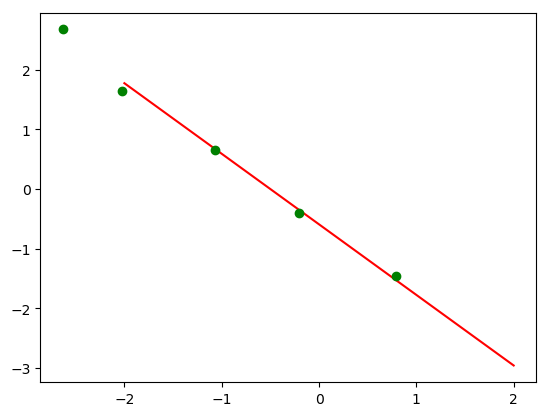

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x13c0cdfd0>

In [24]:
xx = [-2., 2.]
yy = aest .* xx .+ best
p_.plot(xx,yy,"r-")
p_.plot(x,y,"go")